In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the main dataset from an Excel file with specific columns
def load_main_data(excel_path):
    """
    Load the main dataset from the Excel file. 
    Only 'time' and 'Level' columns are read.
    """
    try:
        main_df = pd.read_excel("LevelData.xlsx", usecols=['time', 'Level'])
        main_df['time'] = pd.to_datetime(main_df['time'])  # Ensure 'time' column is datetime
        return main_df
    except Exception as e:
        print(f"Error loading main data: {e}")
        return None

# Load the rainfall forecast data from an Excel file
def load_forecast_data(excel_path):
    """
    Load the forecast data from an Excel file. 
    The Excel file is expected to have 'date' and 'forecast_rainfall' columns.
    """
    try:
        forecast_df = pd.read_excel("ForecastAndHistoric.xlsx")
        forecast_df['date'] = pd.to_datetime(forecast_df['date'])  # Ensure 'date' column is datetime
        return forecast_df.set_index('date')['forecast_rainfall'].to_dict()  # Convert to a dictionary
    except Exception as e:
        print(f"Error loading forecast data: {e}")
        return None

In [18]:
# Path to the Excel files
main_data_path = 'LevelData.xlsx'  # Main dataset (Excel file path)
rainfall_forecast_path = 'ForecastAndHistoric.xlsx'  # Rainfall forecast data (Excel file path)

# Load the data
main_data = load_main_data(main_data_path)
forecast_rainfall = load_forecast_data(rainfall_forecast_path)

# Check only the first 5 rows of the data to avoid large output
if main_data is not None:
    print(main_data.head(5))  # Limiting output to 5 rows

if forecast_rainfall is not None:
    print({k: forecast_rainfall[k] for k in list(forecast_rainfall.keys())[:5]})  # Show only 5 entries

                 time   Level
0 2024-02-05 09:45:00 -2600.0
1 2024-02-05 10:00:00   250.0
2 2024-02-05 10:15:00 -2600.0
3 2024-02-05 10:30:00 -2600.0
4 2024-02-05 10:45:00 -2600.0
{Timestamp('2023-03-01 00:00:00'): 0.0, Timestamp('2023-03-01 00:05:00'): 0.0, Timestamp('2023-03-01 00:10:00'): 0.0, Timestamp('2023-03-01 00:15:00'): 0.0, Timestamp('2023-03-01 00:20:00'): 0.0}


In [19]:

# Define a function to check if a value is negative
def is_negative(value):
    return value < 0



In [20]:
# Black-box function to estimate values using forecast and historical data, and round off the corrected value
def black_box_estimation(index, main_data, forecast_rainfall):
    """
    Estimate the value using a black-box function that averages
    the previous 2-4 readings, forward 2-4 readings, and uses forecast rainfall data.
    The corrected value is rounded off to the nearest integer.
    """
    num_rows = len(main_data)
    current_time = main_data.loc[index, 'time']
    
    # Get the forecasted rainfall value if available, otherwise use 0
    forecasted_rainfall = forecast_rainfall.get(current_time.date(), 0)

    # Get the previous 2-4 readings (within bounds)
    previous_readings = main_data['Level'].iloc[max(0, index-4):index].values
    # Get the forward 2-4 readings (within bounds)
    forward_readings = main_data['Level'].iloc[index+1:min(num_rows, index+5)].values

    # Combine previous and forward readings to compute average
    all_readings = np.concatenate((previous_readings, forward_readings))
    
    # Compute average of the readings
    if len(all_readings) > 0:
        average_readings = np.mean(all_readings)
    else:
        average_readings = 0  # Default to 0 if no readings are available

    # Incorporate forecasted rainfall into the final estimated value
    estimated_value = 0.8 * average_readings + 0.2 * forecasted_rainfall

    # Round off the corrected value to the nearest integer
    corrected_value = round(estimated_value)

    # Ensure that the corrected value is non-negative
    corrected_value = max(corrected_value, 0)

    # Print out the correction details
    print(f"Black-box correction at index {index}: Corrected value = {corrected_value} (was {estimated_value})")
    
    return corrected_value

# Create a copy of the main data to store the corrected values
corrected_data = main_data.copy()

# Iterate through the main data and fix negative values
installation_issue = False
negative_start_time = None
consecutive_negatives = 0

for i in range(len(main_data)):
    level_value = main_data.loc[i, 'Level']
    
    if is_negative(level_value):
        if negative_start_time is None:
            negative_start_time = i
        consecutive_negatives += 1
        
        # Estimate the value using the black-box function
        corrected_data.loc[i, 'Level'] = black_box_estimation(i, main_data, forecast_rainfall)
    else:
        if consecutive_negatives > 0:
            if consecutive_negatives > 12:  # If more than 12 hours of negative values
                installation_issue = True
                print(f"Potential installation issue detected starting at index {negative_start_time}")
            consecutive_negatives = 0
            negative_start_time = None

Black-box correction at index 0: Corrected value = 0 (was -1510.0)
Black-box correction at index 2: Corrected value = 0 (was -1700.0)
Black-box correction at index 3: Corrected value = 0 (was -1754.2857142857142)
Black-box correction at index 4: Corrected value = 0 (was -1795.0)
Black-box correction at index 5: Corrected value = 0 (was -1795.0)
Black-box correction at index 6: Corrected value = 0 (was -2080.0)
Black-box correction at index 7: Corrected value = 0 (was -2080.0)
Black-box correction at index 8: Corrected value = 0 (was -1821.0)
Black-box correction at index 9: Corrected value = 0 (was -1560.5)
Black-box correction at index 10: Corrected value = 0 (was -1299.7)
Black-box correction at index 11: Corrected value = 0 (was -1039.5)
Black-box correction at index 12: Corrected value = 0 (was -1037.1000000000001)
Black-box correction at index 93: Corrected value = 4 (was 3.9000000000000004)
Black-box correction at index 94: Corrected value = 4 (was 4.0)
Black-box correction at in

In [21]:
# Step 2: Check for spikes bigger than 200 mm relative to the previous data
def check_spikes(main_data):
    """
    This function checks for spikes that are more than 130 mm larger than the previous data
    and corrects them if found. If more than 4 consecutive spikes are on the same level,
    they are not averaged. The correction is done by averaging the previous 2-4 values 
    and forward 2-4 values.
    """
    spike_threshold = 130
    corrected_data = main_data.copy()
    consecutive_spikes = 0  # To track consecutive spikes

    for i in range(1, len(main_data) - 1):
        level_value = main_data.loc[i, 'Level']
        previous_value = main_data.loc[i-1, 'Level']
        
        # Check if the spike is more than 200 mm larger than the previous data
        if level_value > previous_value + spike_threshold:
            consecutive_spikes += 1
            
            # Check if it's a single spike (not part of a sequence longer than 4)
            if consecutive_spikes <= 4:
                # Get the previous 2-4 readings (within bounds)
                previous_readings = main_data['Level'].iloc[max(0, i-4):i].values
                # Get the forward 2-4 readings (within bounds)
                forward_readings = main_data['Level'].iloc[i+1:min(len(main_data), i+5)].values
                
                # Combine previous and forward readings to compute average
                all_readings = np.concatenate((previous_readings, forward_readings))
                if len(all_readings) > 0:
                    corrected_value = np.mean(all_readings)
                else:
                    corrected_value = level_value  # If no readings are available, leave the spike as it is
                
                # Apply the correction
                corrected_data.loc[i, 'Level'] = round(corrected_value)
                print(f"Spike detected at index {i} with value {level_value}. Corrected to: {corrected_value}")
        
        else:
            # If no spike is detected, reset consecutive spikes
            if consecutive_spikes > 4:
                print(f"More than 4 consecutive spikes detected starting at index {i - consecutive_spikes}. No correction applied.")
            
            consecutive_spikes = 0  # Reset the consecutive spike count when no spike is detected
    
    return corrected_data

# Apply the spike checking and correction
corrected_data = check_spikes(corrected_data)

# Save the cleaned and corrected data back to a CSV file
corrected_data.to_csv('corrected_level_data.csv', index=False)

Spike detected at index 1 with value 250.0. Corrected to: 0.0
Spike detected at index 15393 with value 150.0. Corrected to: 78.75


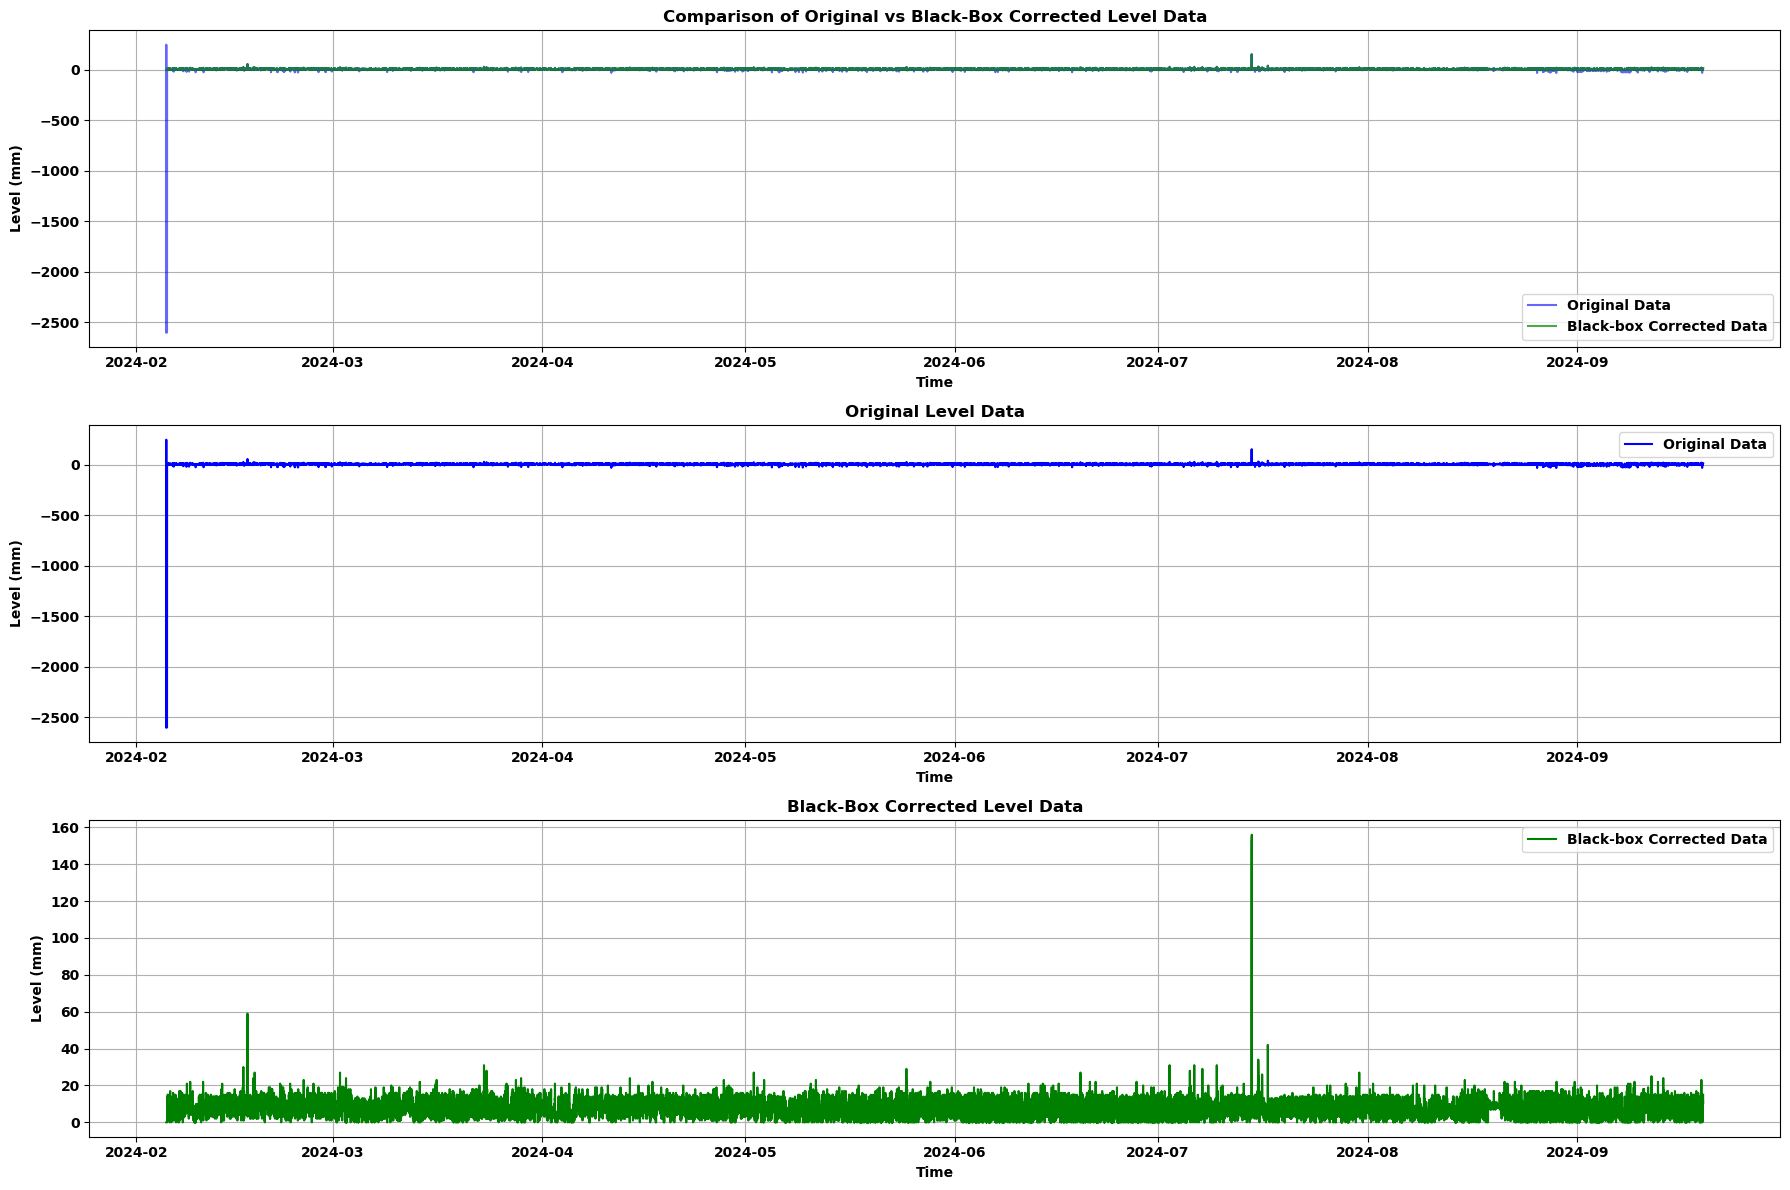

In [22]:
import matplotlib.pyplot as plt

# Create a figure with subplots
plt.figure(figsize=(18, 12))

# Plot 1: Comparison of original and corrected data
plt.subplot(3, 1, 1)
plt.plot(main_data['time'], main_data['Level'], label='Original Data', color='blue', alpha=0.6)
plt.plot(corrected_data['time'], corrected_data['Level'], label='Black-box Corrected Data', color='green', alpha=0.7)
plt.title('Comparison of Original vs Black-Box Corrected Level Data')
plt.xlabel('Time')
plt.ylabel('Level (mm)')
plt.legend()
plt.grid(True)

# Plot 2: Original data only
plt.subplot(3, 1, 2)
plt.plot(main_data['time'], main_data['Level'], label='Original Data', color='blue')
plt.title('Original Level Data')
plt.xlabel('Time')
plt.ylabel('Level (mm)')
plt.legend()
plt.grid(True)

# Plot 3: Black-box corrected data only
plt.subplot(3, 1, 3)
plt.plot(corrected_data['time'], corrected_data['Level'], label='Black-box Corrected Data', color='green')
plt.title('Black-Box Corrected Level Data')
plt.xlabel('Time')
plt.ylabel('Level (mm)')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plots
plt.show()
